In [1]:
import math

import matplotlib.pylab as plt
import pandas as pd
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import train_test_split

from pandas_util import gains_chart, lift_chart, normalize_columns

## Prediction error metrics from a model for Toyota car prices. Training and validation

In [2]:
# Reduce data frame to the top 1000 rows and select columns for regression analysis.
car_df = pd.read_csv("./datasets/dmba/ToyotaCorolla.csv")
normalize_columns(car_df)
car_df.sample(5)

,id,model,price,age_08_04,mfg_month,mfg_year,km,fuel_type,hp,met_color,...,powered_windows,power_steering,radio,mistlamps,sport_model,backseat_divider,metallic_rim,radio_cassette,parking_assistant,tow_bar
697,701,TOYOTA Corolla 1.6 Linea Terra LB 4/5-Doors,9250,67,2,1999,95750,Petrol,110,1,...,0,1,1,0,0,0,0,1,0,0
270,272,TOYOTA Corolla 1.9 D HATCHB TERRA 2/3-Doors,13500,33,12,2001,48928,Diesel,69,1,...,0,1,1,0,0,1,0,1,0,0
655,659,TOYOTA Corolla 1.6 16v Liftback Linea Terra 4/...,8250,59,10,1999,113700,Petrol,110,1,...,0,1,1,0,0,0,0,1,0,1
1284,1291,TOYOTA Corolla 1.6 16V LIFTB LINEA LUNA 4/5-Doors,8950,70,11,1998,73014,Petrol,110,1,...,1,1,0,1,0,1,0,0,0,1
104,105,TOYOTA Corolla 1.6 16V VVT I 3DR TERRA COMF AU...,19450,11,10,2003,14635,Petrol,110,1,...,1,1,0,0,1,1,0,0,0,0


In [3]:
# Create a list of predictor variables by removing output variables and text columns
exclude_columns = "price id model fuel_type color".split()
predictors = [s for s in car_df.columns if s not in exclude_columns]
outcome = "price"

In [4]:
# Partition data.
X = car_df[predictors]
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(
    X, y, test_size=0.4, random_state=1
)

In [5]:
# Train linear regression model
reg = LinearRegression()
reg.fit(train_X, train_y)

# Evaluate performance
# Training
def regression_summary(y_true, y_pred):
    return {
        "Root mean squared error (RMSE)": metrics.mean_squared_error(y_true, y_pred),
        "Mean absolute error (MAE)": metrics.mean_absolute_error(y_true, y_pred),
        "Max error": metrics.max_error(y_true, y_pred),
    }


regression_summary(train_y, reg.predict(train_X))

{'Root mean squared error (RMSE)': 1256776.8345910097,
 'Mean absolute error (MAE)': 811.6770003906788,
 'Max error': 6679.952359929979}

In [6]:
regression_summary(valid_y, reg.predict(valid_X))

{'Root mean squared error (RMSE)': 1910021.3911752158,
 'Mean absolute error (MAE)': 880.1396340851031,
 'Max error': 19983.225248097442}

<AxesSubplot:title={'center':'residual'}, xlabel='[data set]'>

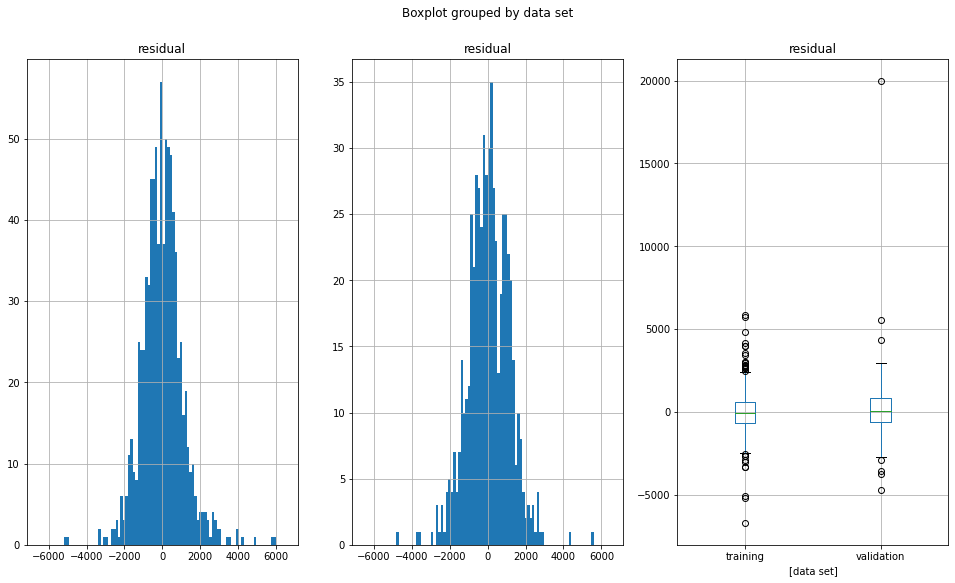

In [7]:
pred_error_train = pd.DataFrame(
    {"residual": train_y - reg.predict(train_X), "data set": "training"}
)
pred_error_valid = pd.DataFrame(
    {"residual": valid_y - reg.predict(valid_X), "data set": "validation"}
)
boxdata_df = pred_error_train.append(pred_error_valid, ignore_index=True)
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(16, 9)
common = {"bins": 100, "range": [-6500, 6500]}
pred_error_train.hist(ax=axes[0], **common)
pred_error_valid.hist(ax=axes[1], **common)
boxdata_df.boxplot(ax=axes[2], by="data set")

In [8]:
# Histograms and boxplots of Toyota price prediction errors, for training and validation sets.

## Gain and lift charts


Gain and lift charts are visual aid for evaluating performance of classification models.


How does it differ from confusion matrix?
- confusion matrix: evaluates the overall population
- gain and lift chart: evaluates model performance in a portion of the population

In short, we evaluate the model in terms of benefit we could get using the model in a portion of the population.


Reference:
1.  https://towardsdatascience.com/model-benefit-evaluation-with-lift-and-gain-analysis-4b69f9288ab3#:~:text=Gain%20and%20lift%20charts%20are,a%20portion%20of%20the%20population.
2. http://www2.cs.uregina.ca/~dbd/cs831/notes/lift_chart/lift_chart.html

In [9]:
# # Get the prediction and order it by descending order
# pred_df = pd.DataFrame(reg.predict(valid_X), columns=["y_pred"], index=valid_X.index)
# pred_df["y_test"] = valid_y
# pred_df.sort_values(by="y_pred", ascending=False, inplace=True)

# # Divide the data into deciles: divide the data into 10 sets and label it.
# # qcut bins the data into different group. However, the largest values will be labelled decile 10 instead of 1, that is why we inverse the range.
# pred_df["decile"] = pd.qcut(pred_df.y_pred, 10, labels=[i for i in range(10, 0, -1)])
# (pred_df.groupby("decile").y_pred.mean() / pred_df.y_test.mean()).sort_values(
#     ascending=False
# ).plot.bar()

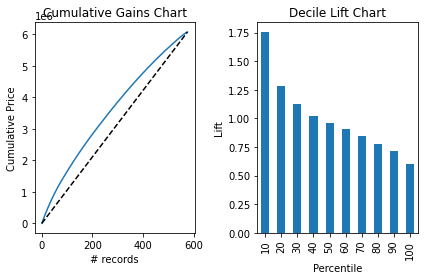

In [10]:
%matplotlib inline

pred_v = pd.Series(reg.predict(valid_X))
pred_v = pred_v.sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gains_chart(pred_v, ax=axes[0])
ax.set_ylabel("Cumulative Price")
ax.set_title("Cumulative Gains Chart")

ax = lift_chart(pred_v, ax=axes[1], labelBars=False)
ax.set_ylabel("Lift")

plt.tight_layout()

In [11]:
df = pd.DataFrame.from_dict(
    [
        {"Customer Name": "Alan", "Height": "70", "Age": "39", "Actual Response": "N"},
        {"Customer Name": "Bob", "Height": "72", "Age": "21", "Actual Response": "Y"},
        {
            "Customer Name": "Jessica",
            "Height": "65",
            "Age": "25",
            "Actual Response": "Y",
        },
        {
            "Customer Name": "Elizabeth",
            "Height": "62",
            "Age": "30",
            "Actual Response": "Y",
        },
        {
            "Customer Name": "Hilary",
            "Height": "67",
            "Age": "19",
            "Actual Response": "Y",
        },
        {"Customer Name": "Fred", "Height": "69", "Age": "48", "Actual Response": "N"},
        {"Customer Name": "Alex", "Height": "65", "Age": "12", "Actual Response": "Y"},
        {
            "Customer Name": "Margot",
            "Height": "63",
            "Age": "51",
            "Actual Response": "N",
        },
        {"Customer Name": "Sean", "Height": "71", "Age": "65", "Actual Response": "Y"},
        {"Customer Name": "Chris", "Height": "73", "Age": "42", "Actual Response": "N"},
        {
            "Customer Name": "Philip",
            "Height": "75",
            "Age": "20",
            "Actual Response": "Y",
        },
        {
            "Customer Name": "Catherine",
            "Height": "70",
            "Age": "23",
            "Actual Response": "N",
        },
        {"Customer Name": "Amy", "Height": "69", "Age": "13", "Actual Response": "N"},
        {"Customer Name": "Erin", "Height": "68", "Age": "35", "Actual Response": "Y"},
        {"Customer Name": "Trent", "Height": "72", "Age": "55", "Actual Response": "N"},
        {
            "Customer Name": "Preston",
            "Height": "68",
            "Age": "25",
            "Actual Response": "N",
        },
        {"Customer Name": "John", "Height": "64", "Age": "76", "Actual Response": "N"},
        {"Customer Name": "Nancy", "Height": "64", "Age": "24", "Actual Response": "Y"},
        {"Customer Name": "Kim", "Height": "72", "Age": "31", "Actual Response": "N"},
        {"Customer Name": "Laura", "Height": "62", "Age": "29", "Actual Response": "Y"},
    ]
)
normalize_columns(df)
df.age = df.age.astype(int)
df.head()

,customer_name,height,age,actual_response
0,Alan,70,39,N
1,Bob,72,21,Y
2,Jessica,65,25,Y
3,Elizabeth,62,30,Y
4,Hilary,67,19,Y


In [12]:
df["p(x)"] = 100 - df.age
df = df.sort_values("p(x)", ascending=False)
df

,customer_name,height,age,actual_response,p(x)
6,Alex,65,12,Y,88
12,Amy,69,13,N,87
4,Hilary,67,19,Y,81
10,Philip,75,20,Y,80
1,Bob,72,21,Y,79
11,Catherine,70,23,N,77
17,Nancy,64,24,Y,76
2,Jessica,65,25,Y,75
15,Preston,68,25,N,75
19,Laura,62,29,Y,71


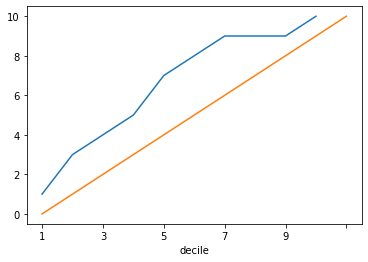

In [13]:
df["responded"] = df["actual_response"] == "Y"
df["decile"] = pd.qcut(df["p(x)"], 10, labels=[i for i in range(10, 0, -1)])

groupby_decile = df.groupby("decile").responded.agg(
    number_of_responses=("sum"), total_customers_contacted=("count")
)
new_df = pd.DataFrame(groupby_decile, index=groupby_decile.index).sort_index(
    ascending=False
)
ax = new_df.number_of_responses.cumsum().plot()
plt.plot([0, 10], [0, new_df.number_of_responses.sum()], axes=ax)

<AxesSubplot:xlabel='decile'>

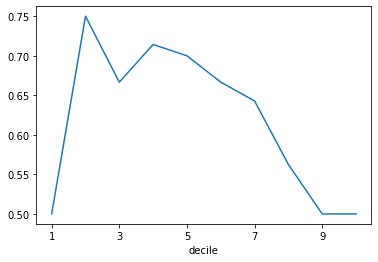

In [14]:
(new_df.number_of_responses.cumsum() / new_df.total_customers_contacted.cumsum()).plot()